In [1]:
import numpy               as np
import scipy               as sp
import matplotlib.pyplot   as pp
import pandas              as pd
import seaborn             as sb

from sklearn                 import metrics
from sklearn.decomposition   import PCA
from sklearn.cluster         import KMeans
from sklearn.mixture         import GaussianMixture
from sklearn.preprocessing   import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold

from collections             import defaultdict

In [2]:
from utility import html, mark, color, hr, compress

hr('SECTION')
html('<b>hi</b>', [1,2,3], color('hello world', weight = 'bold'), color('!!!', weight = 'bold', background = 'black'))
mark('<b>hi</b>', [1,2,3], color('hello world', weight = 'bold'), color('!!!', weight = 'bold', background = 'black'))
hr()

<span                              ><b>hi</b> [1, 2, 3] <span style="color:red;background:transparent;font-family:monospace;font-weight:bold">hello world</span> <span style="color:red;background:black;font-family:monospace;font-weight:bold">!!!</span></span>

In [3]:
train = pd.read_csv('../input/train.csv', parse_dates = ['first_active_month']).set_index('card_id')
test  = pd.read_csv('../input/test.csv',  parse_dates = ['first_active_month']).set_index('card_id')

In [4]:
merchants = pd.read_csv('../input/merchants.csv').set_index('merchant_id')

In [5]:
transactions_old = pd.read_csv('../input/historical_transactions.csv',   parse_dates = ['purchase_date'])
transactions_new = pd.read_csv('../input/new_merchant_transactions.csv', parse_dates = ['purchase_date'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002497CAA7B00>,
      dtype=object)

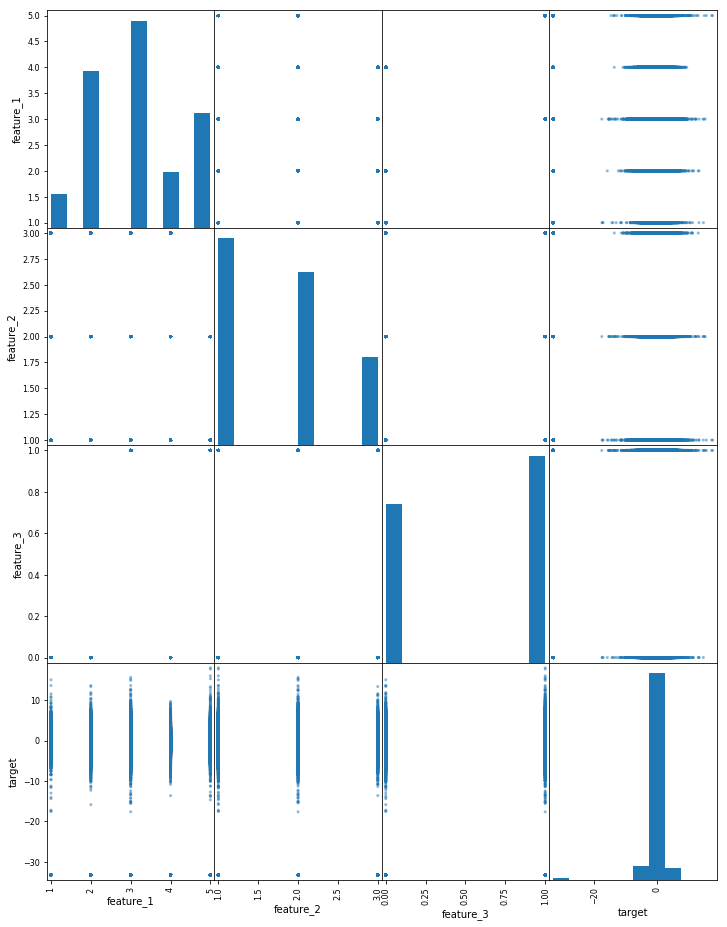

In [6]:
pd.plotting.scatter_matrix(train, figsize = (12,16))

In [7]:
def compress_datasets() :
  # compress the datasets to conserve memory by selecting optimal dtype of each column
    compress(transactions_old)
    compress(transactions_new)
    compress(merchants)
    
compress_datasets()

NameError: name 'np' is not defined

In [ ]:
def initialize() :
    global x_train
    x_train = train.copy().drop(['target'], axis = 1) # train features
    y_train = train.copy().filter(['target'])         # train label
    x_train.count()
    
initialize()

### Purchase Amount

The aggregated purchase amounts from the historical (old) transactions and the recent (new) transactions could be another useful feature that predicts the customer loyalty. Customers should increase or maintain the spending if they are loyal to the specific merchants.

In [ ]:
def add_purchase_amount() :
    global x_train
  # aggregate total purchase amount per card
    purchase_amount_old = transactions_old.groupby(['card_id'])['purchase_amount'].sum().to_frame('old_purchase_amount')
    purchase_amount_new = transactions_new.groupby(['card_id'])['purchase_amount'].sum().to_frame('new_purchase_amount')
  # purchase_amount_rat = purchase_amount_new / purchase_amount_old

  # left join purchase amount on index (card_id), where card_id in train dataset
    x_train = x_train.join(purchase_amount_old[purchase_amount_old.index.isin(train.index)])
    x_train = x_train.join(purchase_amount_new[purchase_amount_new.index.isin(train.index)])
  # x_train = x_train.join(purchase_amount_dlt

add_purchase_amount()

### Merchant Visits

The aggregated merchant visits from the historical (old) transactions and the recent (new) transactions could be another useful feature that predicts the customer loyalty. Customers should increase or maintain the visits if they are loyal to the specific merchants.

In [ ]:
def add_merchant_visits() :
    global x_train    
  # aggregate total merchant visits per card  
    merchant_visits_old = transactions_old.groupby(['card_id'])['merchant_id'].count().to_frame('old_merchant_visits')
    merchant_visits_new = transactions_new.groupby(['card_id'])['merchant_id'].count().to_frame('new_merchant_visits')

  # left join merchant visits on index (card_id), where card_id in train dataset
    x_train = x_train.join(merchant_visits_old[merchant_visits_old.index.isin(train.index)])
    x_train = x_train.join(merchant_visits_new[merchant_visits_new.index.isin(train.index)])

add_merchant_visits()

In [ ]:
x_train.head()